In [1]:
from tqdm.notebook import tqdm_notebook

In [2]:
import torch

In [3]:
def seed_setting(seed = 42) :
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.use_deterministic_algorithms = True

In [4]:
seed_setting()

In [5]:
import torchvision.transforms as transforms

In [33]:
import numpy as np

In [258]:
def train(net, optimizer, criterion, num_epohcs, train_loader, test_loader, device) :

  history = np.zeros((0, 5))

  for epoch in tqdm_notebook(range(num_epochs)) :

    tr_acc, tr_loss, tr_cnt = 0.0, 0.0, 0.0
    te_acc, te_loss, te_cnt = 0.0, 0.0, 0.0

    net.train()

    for image, label in train_loader :
      
      tr_cnt += len(label)

      image = image.to(device)
      label = label.to(device)

      optimizer.zero_grad()

      pred = net(image)

      loss = criterion(pred, label)
      tr_loss += loss.item()
      loss.backward()

      optimizer.step()

      cls = torch.max(pred, 1)[1]
      tr_acc += (cls == label).sum().item()

    avg_tr_acc = tr_acc / tr_cnt
    avg_tr_loss = tr_loss / tr_cnt

    net.eval()
    with torch.no_grad() :
      for image, label in test_loader :

        te_cnt += len(label)

        image = image.to(device)
        label = label.to(device)

        pred = net(image)

        loss = criterion(pred, label)
        te_loss += loss.item()

        cls = torch.max(pred, 1)[1]

        te_acc += (cls == label).sum().item()

      avg_te_acc = te_acc / te_cnt
      avg_te_loss = te_loss / te_cnt

    print(f"Epoch {epoch + 1} Train Accuracy : {avg_tr_acc} / Test Accuracy : {avg_te_acc}")
    history = np.vstack((history, np.array([epoch + 1, avg_tr_acc, avg_tr_loss, avg_te_acc, avg_te_loss])))
  
  return history

In [309]:
import matplotlib.pyplot as plt
%matplotlib inline

In [311]:
def plotting_history(history):

    num_epochs = len(history)
    unit = num_epochs / 10

    plt.figure(figsize = (9, 8))
    plt.plot(history[:,0], history[:,2], 'b', label = 'Train')
    plt.plot(history[:,0], history[:,4], 'r', label = 'Test')
    plt.xticks(np.arange(0, num_epochs + 1, unit))
    plt.xlabel('Num Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize = (9, 8))
    plt.plot(history[:,0], history[:,1], 'b', label = 'Train')
    plt.plot(history[:,0], history[:,3], 'r', label = 'Test')
    plt.xticks(np.arange(0, num_epochs + 1, unit))
    plt.xlabel('Num Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [11]:
import torchvision.datasets as datasets
from torchvision.transforms import Compose, ToTensor, Normalize

In [10]:
data_root = './data'

In [14]:
transform = Compose([
    ToTensor(),
    Normalize(0.5, 0.5)
])

In [45]:
train_set = datasets.CIFAR10(root = data_root, train = True, download = True, transform = transform)
test_set = datasets.CIFAR10(root = data_root, train = False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
len(train_set)

50000

In [17]:
bs = 1024

In [18]:
from torch.utils.data import DataLoader

In [64]:
tr_loader = DataLoader(train_set, batch_size = bs, shuffle = True)
te_loader = DataLoader(test_set, batch_size = bs, shuffle = False)

In [20]:
import torch.nn as nn
from torch.optim import Adam

In [315]:
### Linear 층으로 들어가는 in_features의 수 구하기 -> 일단 샘플 데이터로 구하기
### 추후에 수식 계산만으로 알아낼 수 있어야 할듯...

samp = torch.randn(bs, 3, 32, 32)

conv1 = nn.Conv2d(3, 32, 3)
bn1 = nn.BatchNorm2d(32)
relu1 = nn.ReLU()
mp1 = nn.MaxPool2d((2, 2))
conv2 = nn.Conv2d(32, 32, 3)
bn2 = nn.BatchNorm2d(32)
relu2 = nn.ReLU()
mp2 = nn.MaxPool2d((2, 2))

f = nn.Sequential(
    conv1,
    bn1,
    relu1,
    mp1,
    conv2,
    bn2,
    relu2,
    mp2
)

flatten = nn.Flatten()

p = f(samp)

print(f"in_features : {flatten(p).shape[1]}")

in_features : 1152


In [297]:
class CNN(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.mp1 = nn.MaxPool2d((2, 2))
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.bn2 = nn.BatchNorm2d(32)
    self.relu2 = nn.ReLU()
    self.mp2 = nn.MaxPool2d((2, 2))
    self.ln1 = nn.Linear(1152, 128) # 위에서 구한 in_features 1152
    self.ln2 = nn.Linear(128, 32)
    self.ln3 = nn.Linear(32, 10)

  def forward(self, x) :
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.mp1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.mp2(x)
    x = x.view(x.size(0), -1)
    x = self.ln1(x)
    x = self.ln2(x)
    x = self.ln3(x)

    return x

In [298]:
net = CNN()

In [299]:
criterion = nn.CrossEntropyLoss()

In [300]:
lr = 0.003

In [301]:
optimizer = Adam(net.parameters(), lr = lr)

In [302]:
net

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (mp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (mp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (ln1): Linear(in_features=1152, out_features=128, bias=True)
  (ln2): Linear(in_features=128, out_features=32, bias=True)
  (ln3): Linear(in_features=32, out_features=10, bias=True)
)

In [303]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [304]:
device

'cuda:0'

In [305]:
net = net.to(device)

In [306]:
num_epochs = 20

In [307]:
history = train(net, optimizer, criterion, num_epochs, tr_loader, te_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Train Accuracy : 0.35804 / Test Accuracy : 0.4728
Epoch 2 Train Accuracy : 0.52846 / Test Accuracy : 0.5539
Epoch 3 Train Accuracy : 0.60248 / Test Accuracy : 0.6179
Epoch 4 Train Accuracy : 0.644 / Test Accuracy : 0.6152
Epoch 5 Train Accuracy : 0.67722 / Test Accuracy : 0.6522
Epoch 6 Train Accuracy : 0.68578 / Test Accuracy : 0.6305
Epoch 7 Train Accuracy : 0.70054 / Test Accuracy : 0.6508
Epoch 8 Train Accuracy : 0.71018 / Test Accuracy : 0.6683
Epoch 9 Train Accuracy : 0.71984 / Test Accuracy : 0.6736
Epoch 10 Train Accuracy : 0.72514 / Test Accuracy : 0.6698
Epoch 11 Train Accuracy : 0.73162 / Test Accuracy : 0.6762
Epoch 12 Train Accuracy : 0.73992 / Test Accuracy : 0.6886
Epoch 13 Train Accuracy : 0.74406 / Test Accuracy : 0.6799
Epoch 14 Train Accuracy : 0.74776 / Test Accuracy : 0.6971
Epoch 15 Train Accuracy : 0.74922 / Test Accuracy : 0.6707
Epoch 16 Train Accuracy : 0.76034 / Test Accuracy : 0.6943
Epoch 17 Train Accuracy : 0.758 / Test Accuracy : 0.7021
Epoch 18 T

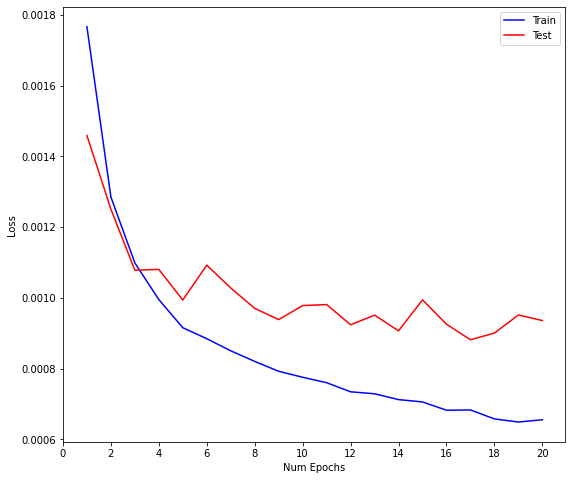

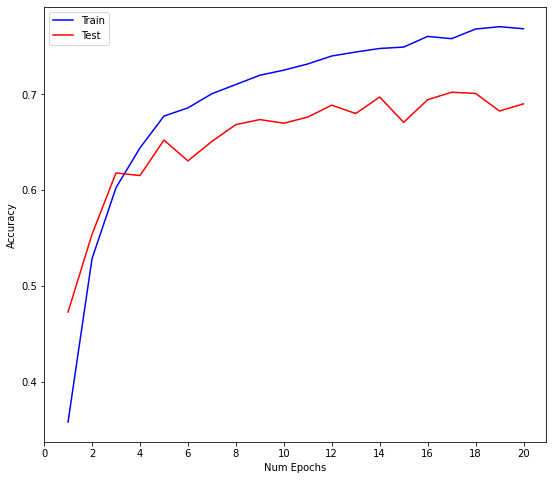

In [312]:
plotting_history(history)